In [1]:
import os, requests, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.inspection import permutation_importance

from IPython.display import Image

# from utils import retrieve_data_orientation, circular_encoding

In [2]:
def retrieve_data_orientation() -> np.array:
    """
    Retrieve Stringer et al. (2019) orientation data from OSF repository.

    Returns:
        dat (np.array): array of orientation data
    """
    fpath = "./data/stringer_orientations.npy"
    url = "https://osf.io/ny4ut/download"

    if not os.path.exists(fpath):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fpath, "wb") as fid:
                    fid.write(r.content)

    dat = np.load('./data/stringer_orientations.npy', allow_pickle=True).item()
    return dat

def circular_encoding(angle: np.array) -> tuple[np.array, np.array]:
    """
    Encode an angle into a pair of coordinates using sine and cosine functions.
    Angle should be in radians.

    Args:
        angle (float): angle in radians

    Returns:
        x, y (float): coordinates
    """
    x = np.cos(angle)
    y = np.sin(angle)
    return x, y


### Plot Arguments

In [3]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

### Load Data

In [4]:
dat = retrieve_data_orientation()
cdepths = np.load('./data/all_depths.npy',allow_pickle=True)

dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain.
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

### Split Neuron Layer

Because we're investigating neurons by layer, it is helpful to first investigate the layers and split neurons by assigning them labels.

In [5]:
gather_lengths = []
for i in range(cdepths.shape[0]):
  gather_lengths.append(cdepths[i].shape[0])

print('avg number of neurons per session:', np.mean(gather_lengths))

avg number of neurons per session: 18496.09375


Text(0, 0.5, 'cortical depth')

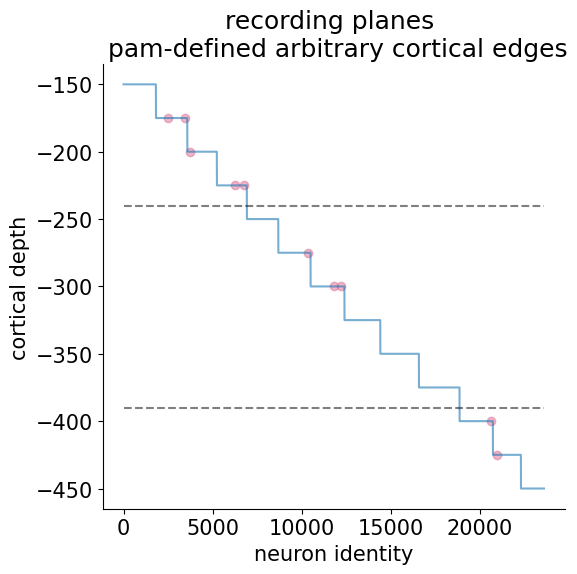

In [6]:
session = 0

_, _, z = dat['xyz'] #position coordinates per neuron

fig = plt.figure(figsize=(6,6))

plt.plot(-cdepths[session],alpha=0.6)
plt.hlines(y = -240,
           xmin = 0,
           xmax = cdepths[session].shape,
           color='k', linestyle='--',
           alpha=0.5
           )
plt.hlines(y = -390,
           xmin = 0,
           xmax = cdepths[session].shape,
           color='k', linestyle='--',
           alpha=0.5
           )

#plot the depths of a couple of randomly sampled neurons
idx_list = np.random.choice(cdepths[session].shape[0], 10)
for i in idx_list:
  plt.scatter(i,z[i],color='palevioletred',alpha=0.5)

plt.title('recording planes \n pam-defined arbitrary cortical edges')
plt.xlabel('neuron identity')
plt.ylabel('cortical depth')

For now, define the edges of each layer arbitrarily, just to get the labeling code running, then revise!

Update: Josien said edges typically are:
* layer 2/3 up to -250 um
* layer 4 between -250 to -370 um
* layer 5 below this

In [7]:
layer_labels = ['2/3', '4', '5']
gather_layers = []

for i in z:
  if (i <= -150) & (i >= -240):
    gather_layers.append(layer_labels[0])

  elif (i < -240) & (i >= -370):
    gather_layers.append(layer_labels[1])

  elif i < -370:
    gather_layers.append(layer_labels[2])

dat['layer_labels'] = np.asarray(gather_layers)
print('layer labels:', np.unique(dat['layer_labels']))
print('layer shape:', dat['layer_labels'].shape)

layer labels: ['2/3' '4' '5']
layer shape: (23589,)


In [8]:
print(np.where(dat['layer_labels'] == '2/3'))
print(f'number of 2/3 neurons: {np.where(dat["layer_labels"] == "2/3")[0].shape[0]}')
print(np.where(dat['layer_labels'] == '4'))
print(f'number of 4 neurons: {np.where(dat["layer_labels"] == "4")[0].shape[0]}')
print(np.where(dat['layer_labels'] == '5'))
print(f'number of 5 neurons: {np.where(dat["layer_labels"] == "5")[0].shape[0]}')

(array([   0,    1,    2, ..., 6913, 6914, 6915], dtype=int64),)
number of 2/3 neurons: 6916
(array([ 6916,  6917,  6918, ..., 16567, 16568, 16569], dtype=int64),)
number of 4 neurons: 9654
(array([16570, 16571, 16572, ..., 23586, 23587, 23588], dtype=int64),)
number of 5 neurons: 7019


Wait, so the neurons order does matter! It looks like neurons 0-6915 are in layer 2/3, neurons 6916-16569 are in layer 4, and neurons 16570-23588 are in layer 5.

### Process Orientation Data

For each trials, the subject is shown an orientation ranging from 0-2pi rad. This data is not very helpful for us because 0 and 2pi are technically the same angle. We want to preprocess the orientation data to reflect that. Specifically, we will map each angle to a Cartesian coordinate, with x and y that are all equidistant from the center. In other words, we plot (1, angle) in polar coordinates.

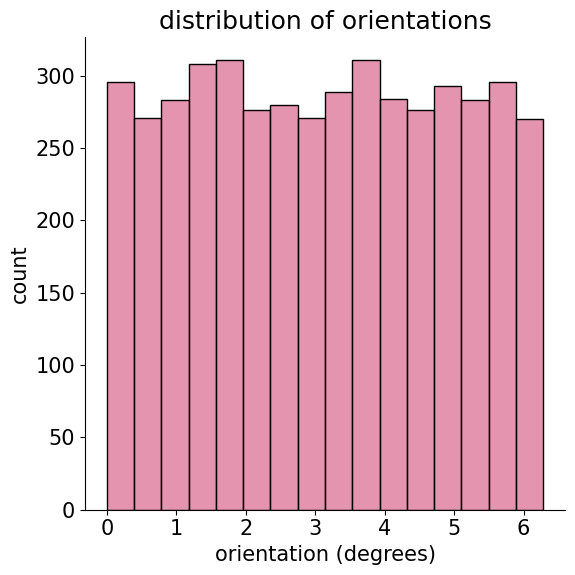

In [9]:
#plot the distribution of orientations
plt.figure(figsize=(6,6))
sns.histplot(dat['istim'], bins=16, color='palevioletred')
plt.title('distribution of orientations')
plt.xlabel('orientation (degrees)')
plt.ylabel('count')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


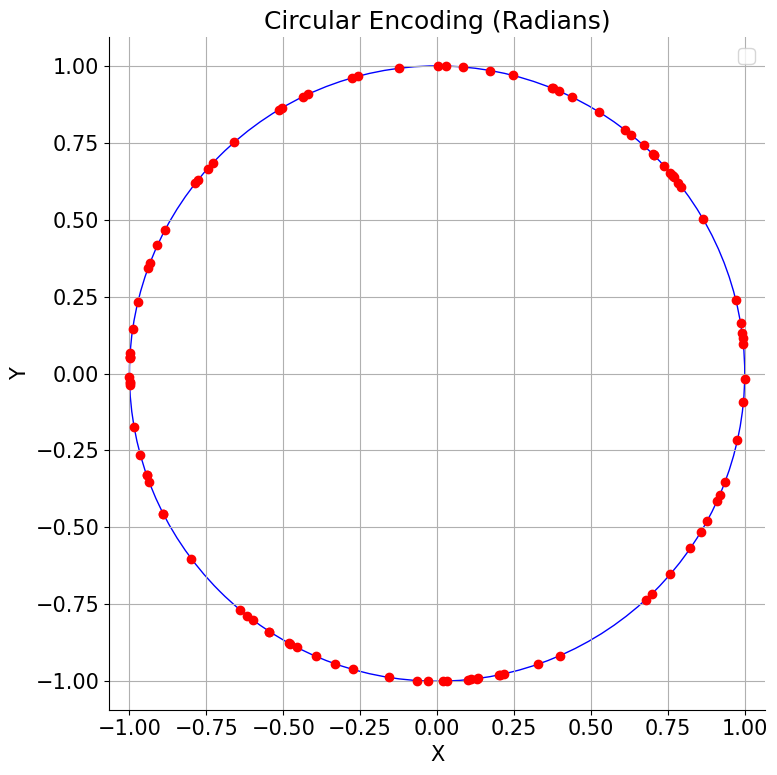

In [10]:
# Create the plot
plt.figure(figsize=(8, 8))

# Plot the unit circle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

random_angles = np.random.choice(dat['istim'], 100)

for angle in random_angles:
    x, y = circular_encoding(angle)
    plt.plot(x, y, 'ro')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Circular Encoding (Radians)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
istim_x = np.zeros(dat['istim'].shape)
istim_y = np.zeros(dat['istim'].shape)

for idx, ori in enumerate(dat['istim']):
    x, y = circular_encoding(ori)
    istim_x[idx] = x
    istim_y[idx] = y


dat['istim_x'] = istim_x
dat['istim_y'] = istim_y

This is one way... but I think I have a better idea!

If we just run the angle through cosine, closer angles will be closer in value to each others! cos(0) and cos(2pi) are both 1.

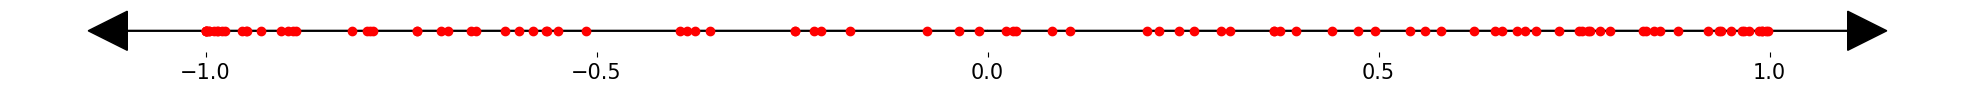

In [12]:
# Create the plot
# Create a figure and an axis
fig, ax = plt.subplots()

# Set the axis limits
ax.set_xlim(-1.25, 1.25)

# Remove y-axis
ax.get_yaxis().set_visible(False)
# Center x-axis
ax.set_aspect('equal')

# add arrows
ax.arrow(0, 0, 1.1, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')
ax.arrow(0, 0, -1.1, 0, head_width=0.05, head_length=0.05, fc='k', ec='k')

# remove border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

random_angles = np.random.choice(dat['istim'], 100)

for angle in random_angles:
    cosine_value = np.cos(angle)
    plt.plot(cosine_value, 0, marker='o', color='red')

plt.show()

In [13]:
dat['istim_cos'] = np.abs(np.cos(dat['istim']))

This way, we can actually use a DecisionTree (regressor or classifier) to predict the angles instead. However, this seems to force many data points to be clustered more to -1.0 or 1.0. This could be bad for data balance.

With the circular encoding data having 2 data points instead of 1, we either have to have 2 DecisionTrees training at the same time (1 for x, 1 for y), or a neural net.

### Training time!!!

For now, I'm using regular angle data from `dat['istim']` with 5 degrees bins.

#### Preparing Data

In [14]:
angles = np.arange(0, 2 * np.pi, (2 * np.pi) / 72)
angles = np.append(angles, 2 * np.pi)
angles_dict = {}

for i in range(36):
  angles_dict[i] = ((angles[i], angles[i + 1]), (angles[i + 36], angles[i + 37]))

dat['ori'] = np.array([])

for i in range(len(dat['istim'])):
  for j in range(36):
    if (dat['istim'][i] >= angles_dict[j][0][0] and dat['istim'][i] <= angles_dict[j][0][1]) or (dat['istim'][i] >= angles_dict[j][1][0] and dat['istim'][i] <= angles_dict[j][1][1]):
      dat['ori'] = np.append(dat['ori'], j)

print(dat['ori'].shape)

(4598,)


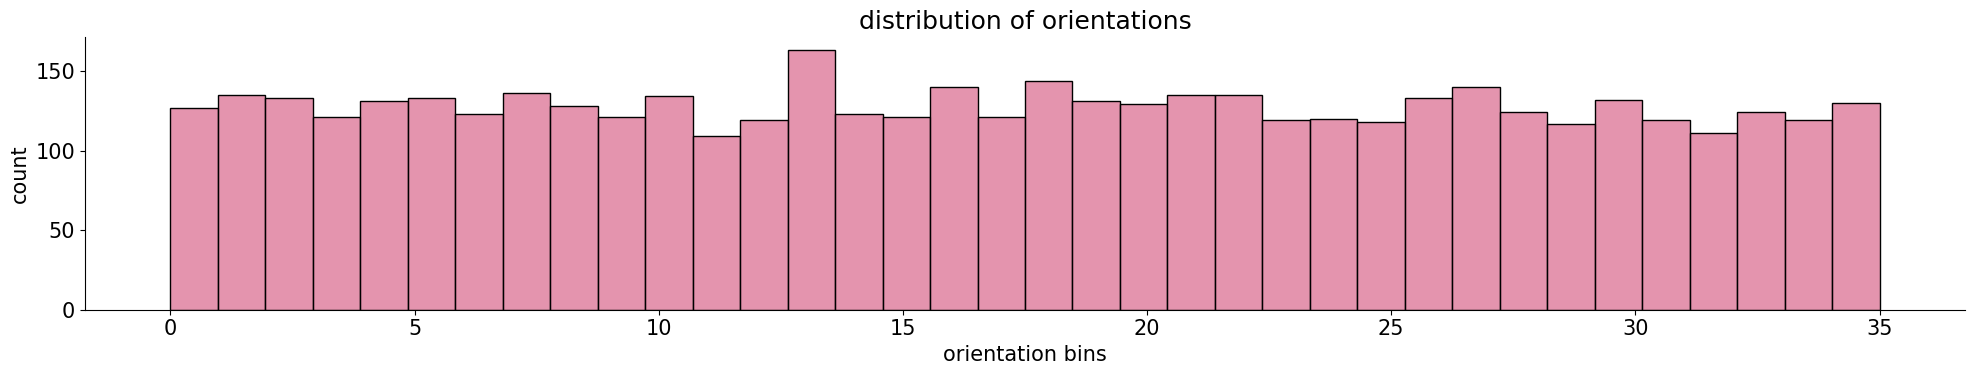

In [15]:
sns.histplot(dat['ori'], bins=36, color='palevioletred')
plt.title('distribution of orientations')
plt.xlabel('orientation bins')
plt.ylabel('count')
plt.show()

In [16]:
sresp_df = pd.DataFrame(dat['sresp'].T)
sresp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23579,23580,23581,23582,23583,23584,23585,23586,23587,23588
0,53.483261,20.518503,0.000000,578.916809,1.836931,568.025085,208.385452,10.627718,0.000000,914.985901,...,0.713030,13.767550,0.000000,12.340549,10.835267,0.000000,3.518415,0.00000,16.479868,7.973795
1,63.134762,2.379957,0.000000,14.064929,6.834842,661.878601,85.330322,0.000000,0.000000,238.626938,...,0.572336,1.329864,0.000000,0.000000,0.000000,0.000000,4.695301,0.00000,0.000000,0.000000
2,62.432125,0.000000,0.000000,0.000000,12.260544,767.102600,52.511433,0.000000,0.000000,155.803101,...,0.690646,0.000000,10.962273,4.433188,6.063787,5.905285,0.000000,4.99042,5.061645,31.222448
3,156.087830,0.000000,6.526441,586.897522,2.147522,82.771744,365.861115,0.000000,41.978580,0.000000,...,0.657146,2.781556,0.000000,0.000000,0.000000,2.372391,0.000000,0.00000,0.000000,0.000000
4,374.028961,5.017585,1.136153,20.846800,0.000000,224.130447,6.452364,0.167832,772.317444,0.000000,...,0.000000,0.120470,0.000000,0.000000,0.637336,11.290267,0.000000,0.00000,0.000000,0.000000


In [17]:
# create a dataframe for each layer

sresp_2_3_df = sresp_df[np.where(dat['layer_labels'] == '2/3')[0]]
sresp_4_df = sresp_df[np.where(dat['layer_labels'] == '4')[0]]
sresp_5_df = sresp_df[np.where(dat['layer_labels'] == '5')[0]]

# test to see if the dataframe columns match the np.where indices
print(f'2/3 df columns match indices: {np.all(sresp_2_3_df.columns == np.where(dat["layer_labels"] == "2/3")[0])}')
print(f'4 df columns match indices: {np.all(sresp_4_df.columns == np.where(dat["layer_labels"] == "4")[0])}')
print(f'5 df columns match indices: {np.all(sresp_5_df.columns == np.where(dat["layer_labels"] == "5")[0])}')

2/3 df columns match indices: True
4 df columns match indices: True
5 df columns match indices: True


In [18]:
# count the number of neurons in each layer
print(f'all layers: {sresp_df.shape[1]}')
print(f'number of 2/3 neurons: {sresp_2_3_df.shape[1]}')
print(f'number of 4 neurons: {sresp_4_df.shape[1]}')
print(f'number of 5 neurons: {sresp_5_df.shape[1]}')

all layers: 23589
number of 2/3 neurons: 6916
number of 4 neurons: 9654
number of 5 neurons: 7019


In [19]:
# split the data into train and test sets
# this approach is undesirable because the test set neurons will not be considered for importance
# We'll do k-fold cross validation instead

X, y = sresp_df, dat['ori']
X_2_3, y_2_3 = sresp_2_3_df, dat['ori']
X_4, y_4 = sresp_4_df, dat['ori']
X_5, y_5 = sresp_5_df, dat['ori']

kf = KFold(n_splits=5, shuffle=True, random_state=1)

""" X_train, X_test, y_train, y_test = train_test_split(sresp_df, dat['ori'], test_size=0.3, random_state=1)
X_2_3_train, X_2_3_test, y_2_3_train, y_2_3_test = train_test_split(sresp_2_3_df, dat['ori'], test_size=0.3, random_state=1)
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(sresp_4_df, dat['ori'], test_size=0.3, random_state=1)
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(sresp_5_df, dat['ori'], test_size=0.3, random_state=1) """

" X_train, X_test, y_train, y_test = train_test_split(sresp_df, dat['ori'], test_size=0.3, random_state=1)\nX_2_3_train, X_2_3_test, y_2_3_train, y_2_3_test = train_test_split(sresp_2_3_df, dat['ori'], test_size=0.3, random_state=1)\nX_4_train, X_4_test, y_4_train, y_4_test = train_test_split(sresp_4_df, dat['ori'], test_size=0.3, random_state=1)\nX_5_train, X_5_test, y_5_train, y_5_test = train_test_split(sresp_5_df, dat['ori'], test_size=0.3, random_state=1) "

#### Training

In [30]:
def get_confusion_matrix(model: DecisionTreeClassifier, X_test: np.array, y_test: np.array) -> ConfusionMatrixDisplay:
    """
    Get confusion matrix for classification model.

    Args:
        model: trained classification model
        X (np.array): input data
        y (np.array): target data

    Returns:
        disp: confusion matrix display
    """
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    print(f'Accuracy on all data: {model.score(X_test, y_test)}')
    return disp

In [32]:
def train_kfold(model: DecisionTreeClassifier, X: np.array, y: np.array, kf: KFold, label: str) -> DecisionTreeClassifier:
    fold_accuracy = []
    for i, (train_index, test_index) in tqdm(enumerate(kf.split(X)), desc=label, total=kf.get_n_splits()):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        fold_accuracy.append(model.score(X_test, y_test))


    print(f'Average accuracy: {np.mean(fold_accuracy)}')
    fig, ax = plt.subplots(figsize=(25, 25))
    disp = get_confusion_matrix(model, X, y)
    disp.plot(ax=ax)
    plt.title(f'Confusion Matrix for {label}', fontsize=40)
    plt.show()

    return model

All Layers: 100%|██████████| 5/5 [05:56<00:00, 71.22s/it]


Average accuracy: 0.31165610067653876
Accuracy on all data: 0.7333623314484559


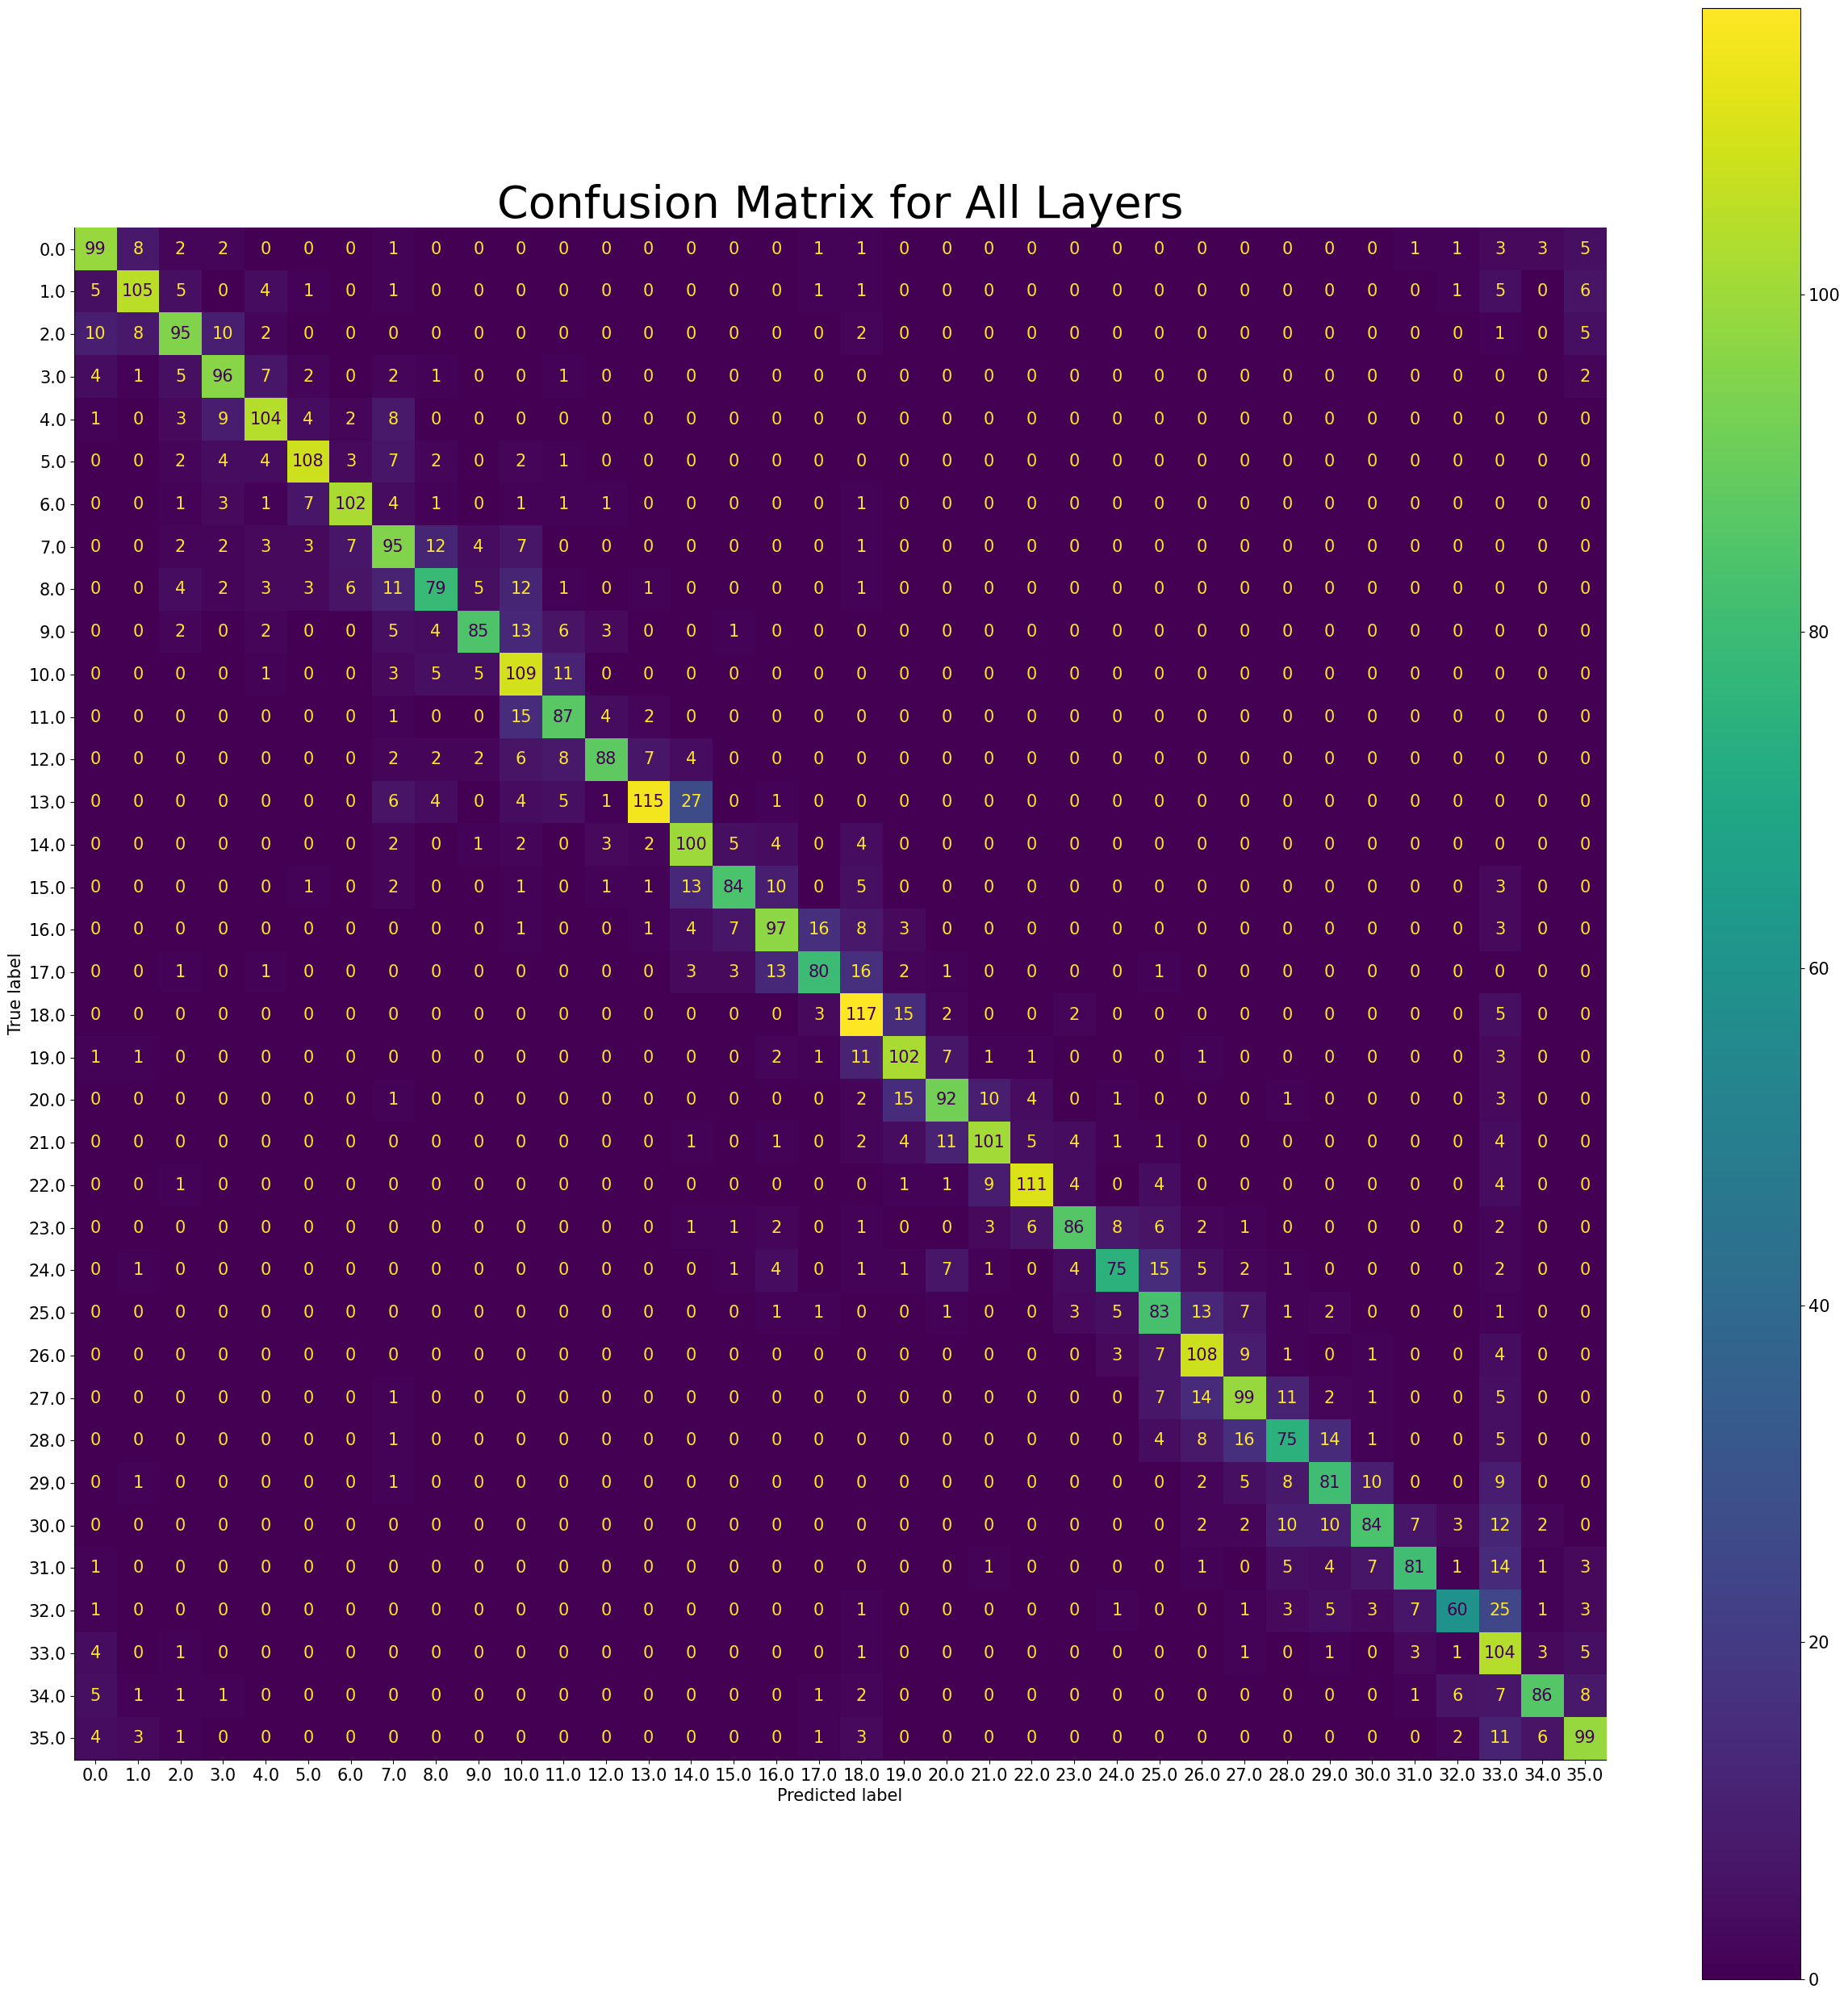

CPU times: total: 5min 59s
Wall time: 5min 59s


In [33]:
%%time
full_tree = train_kfold(DecisionTreeClassifier(max_depth=10), X, y, kf, 'All Layers')

2/3 Layer: 100%|██████████| 5/5 [01:37<00:00, 19.46s/it]


Average accuracy: 0.2892484742394853
Accuracy on all data: 0.7007394519356241


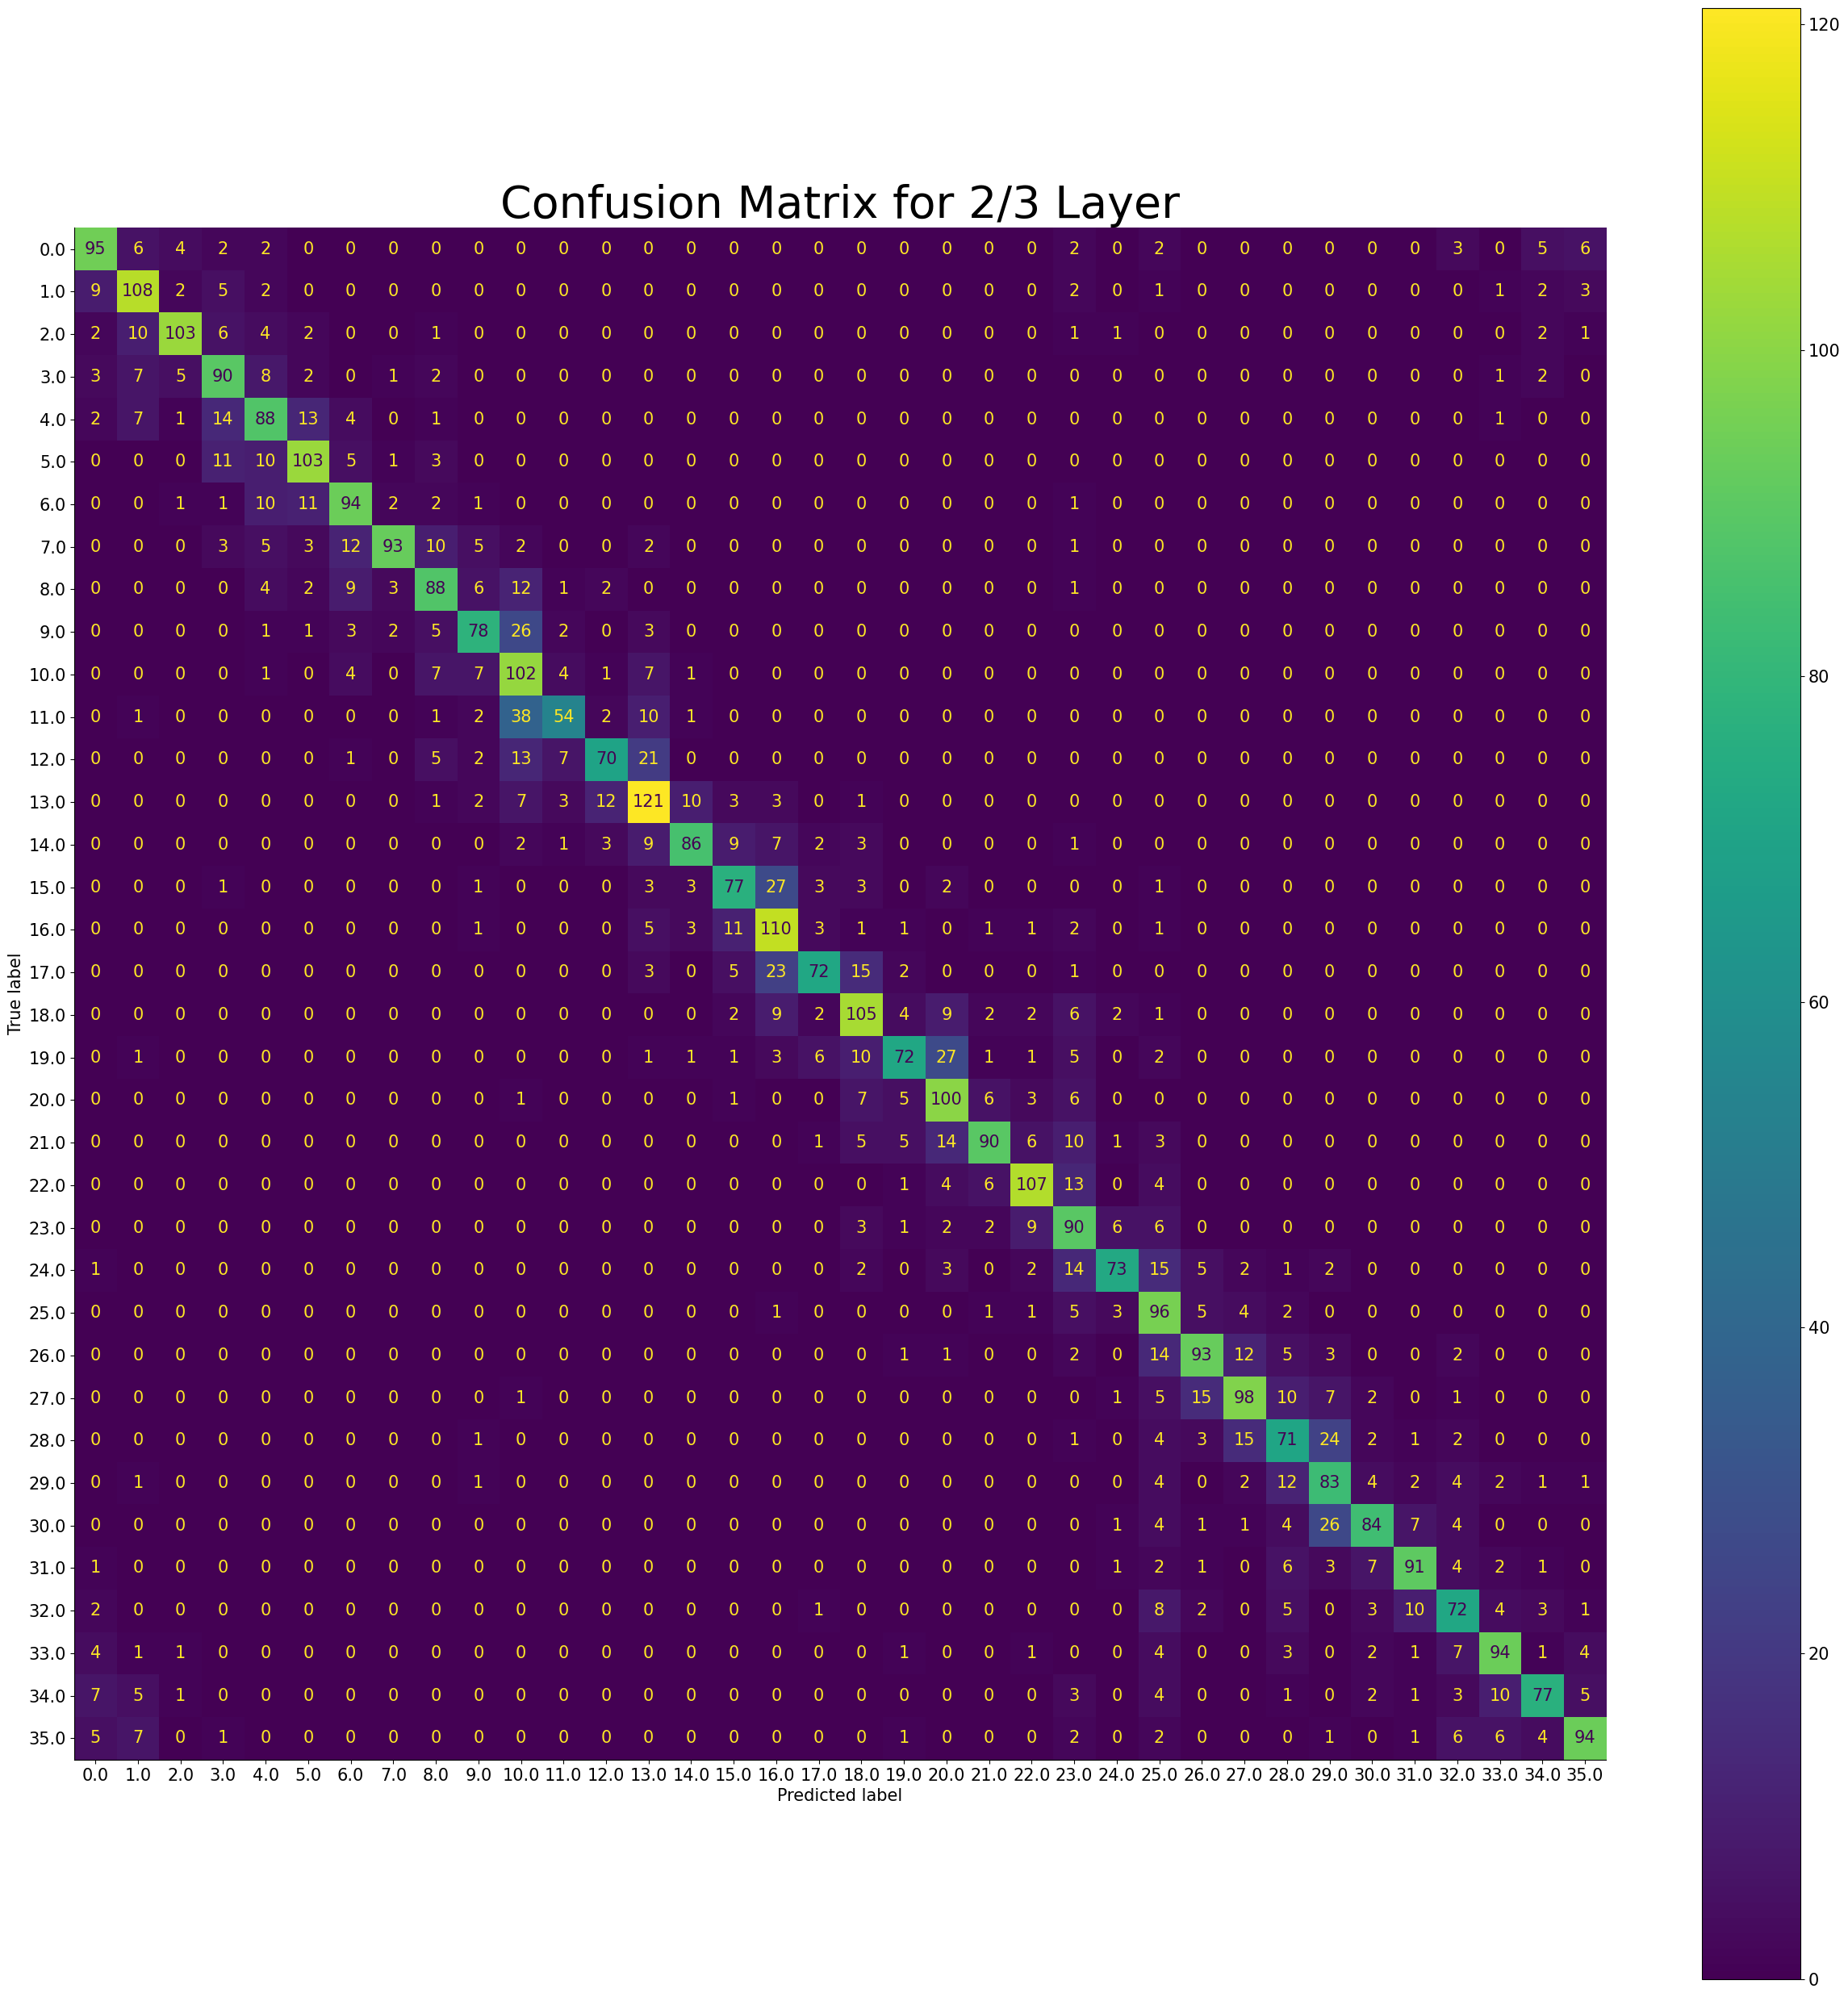

CPU times: total: 1min 39s
Wall time: 1min 39s


In [37]:
%%time
tree_2_3 = train_kfold(DecisionTreeClassifier(max_depth=10), X_2_3, y_2_3, kf, '2/3 Layer')

4 Layer: 100%|██████████| 5/5 [02:20<00:00, 28.18s/it]


Average accuracy: 0.2870785825803094
Accuracy on all data: 0.6622444541104828


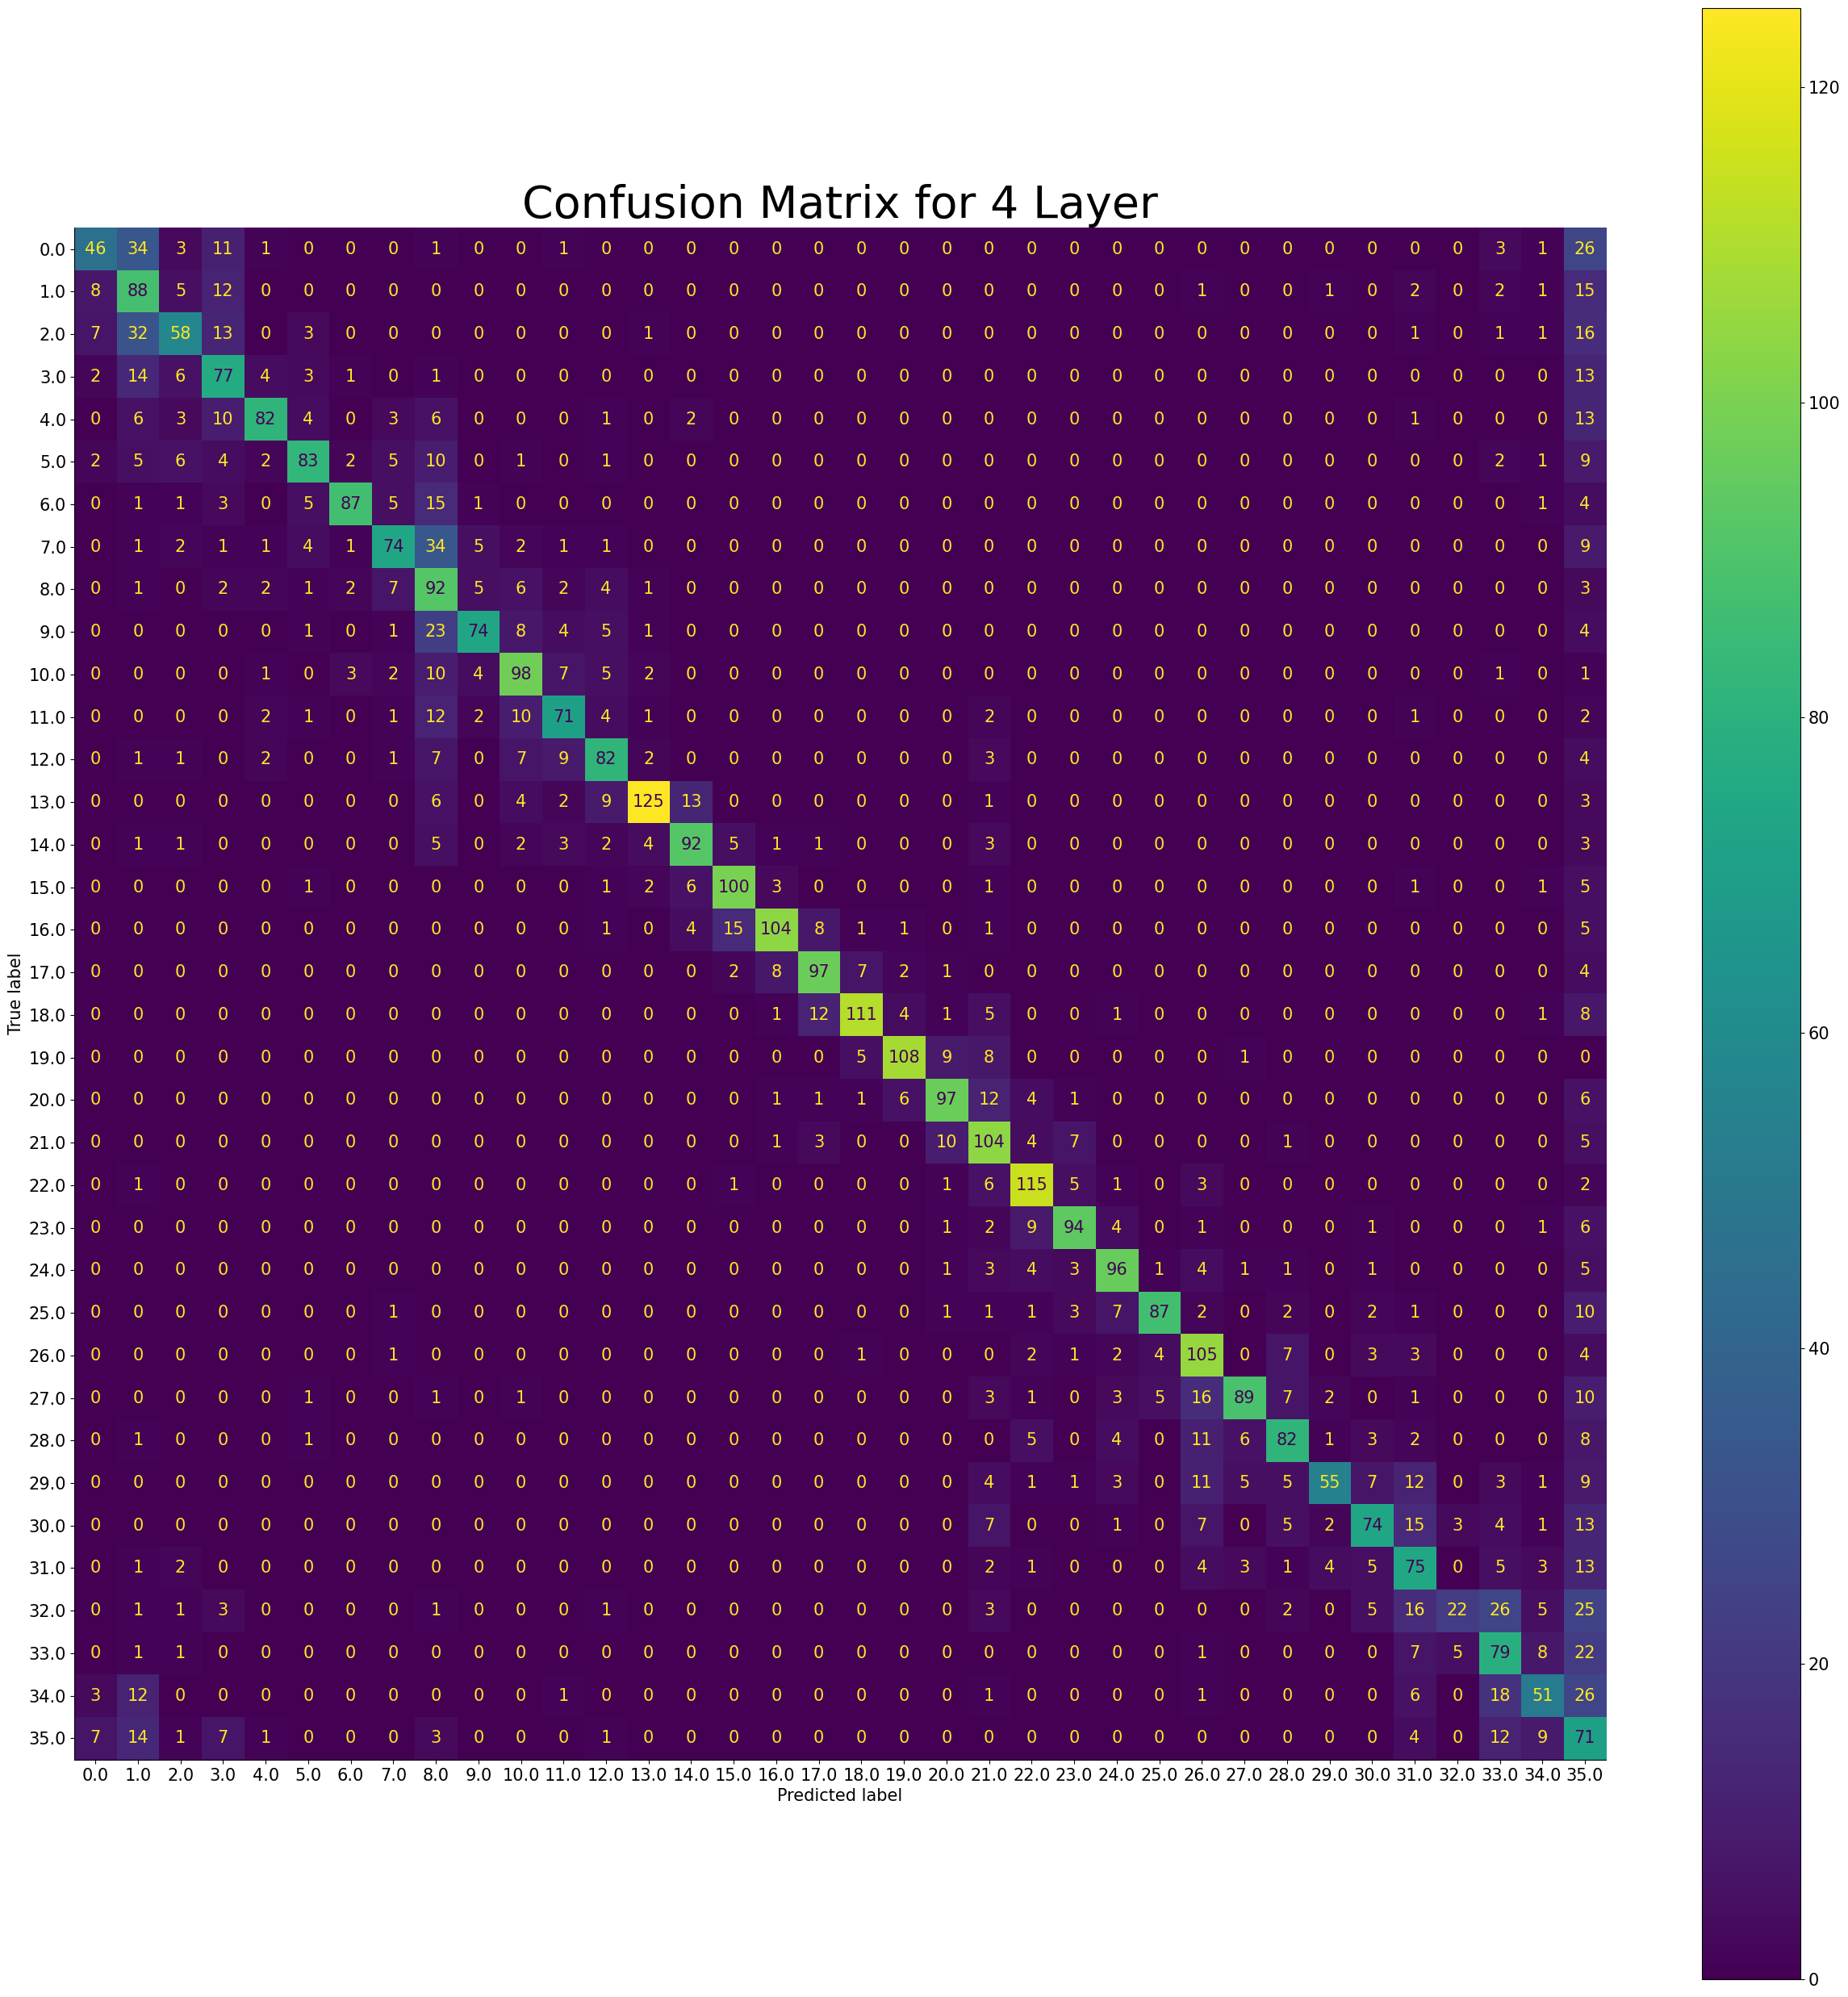

CPU times: total: 2min 23s
Wall time: 2min 23s


In [38]:
%%time
tree_4 = train_kfold(DecisionTreeClassifier(max_depth=10), X_4, y_4, kf, '4 Layer')

5 Layer: 100%|██████████| 5/5 [01:44<00:00, 20.98s/it]


Average accuracy: 0.2788186592231632
Accuracy on all data: 0.6561548499347543


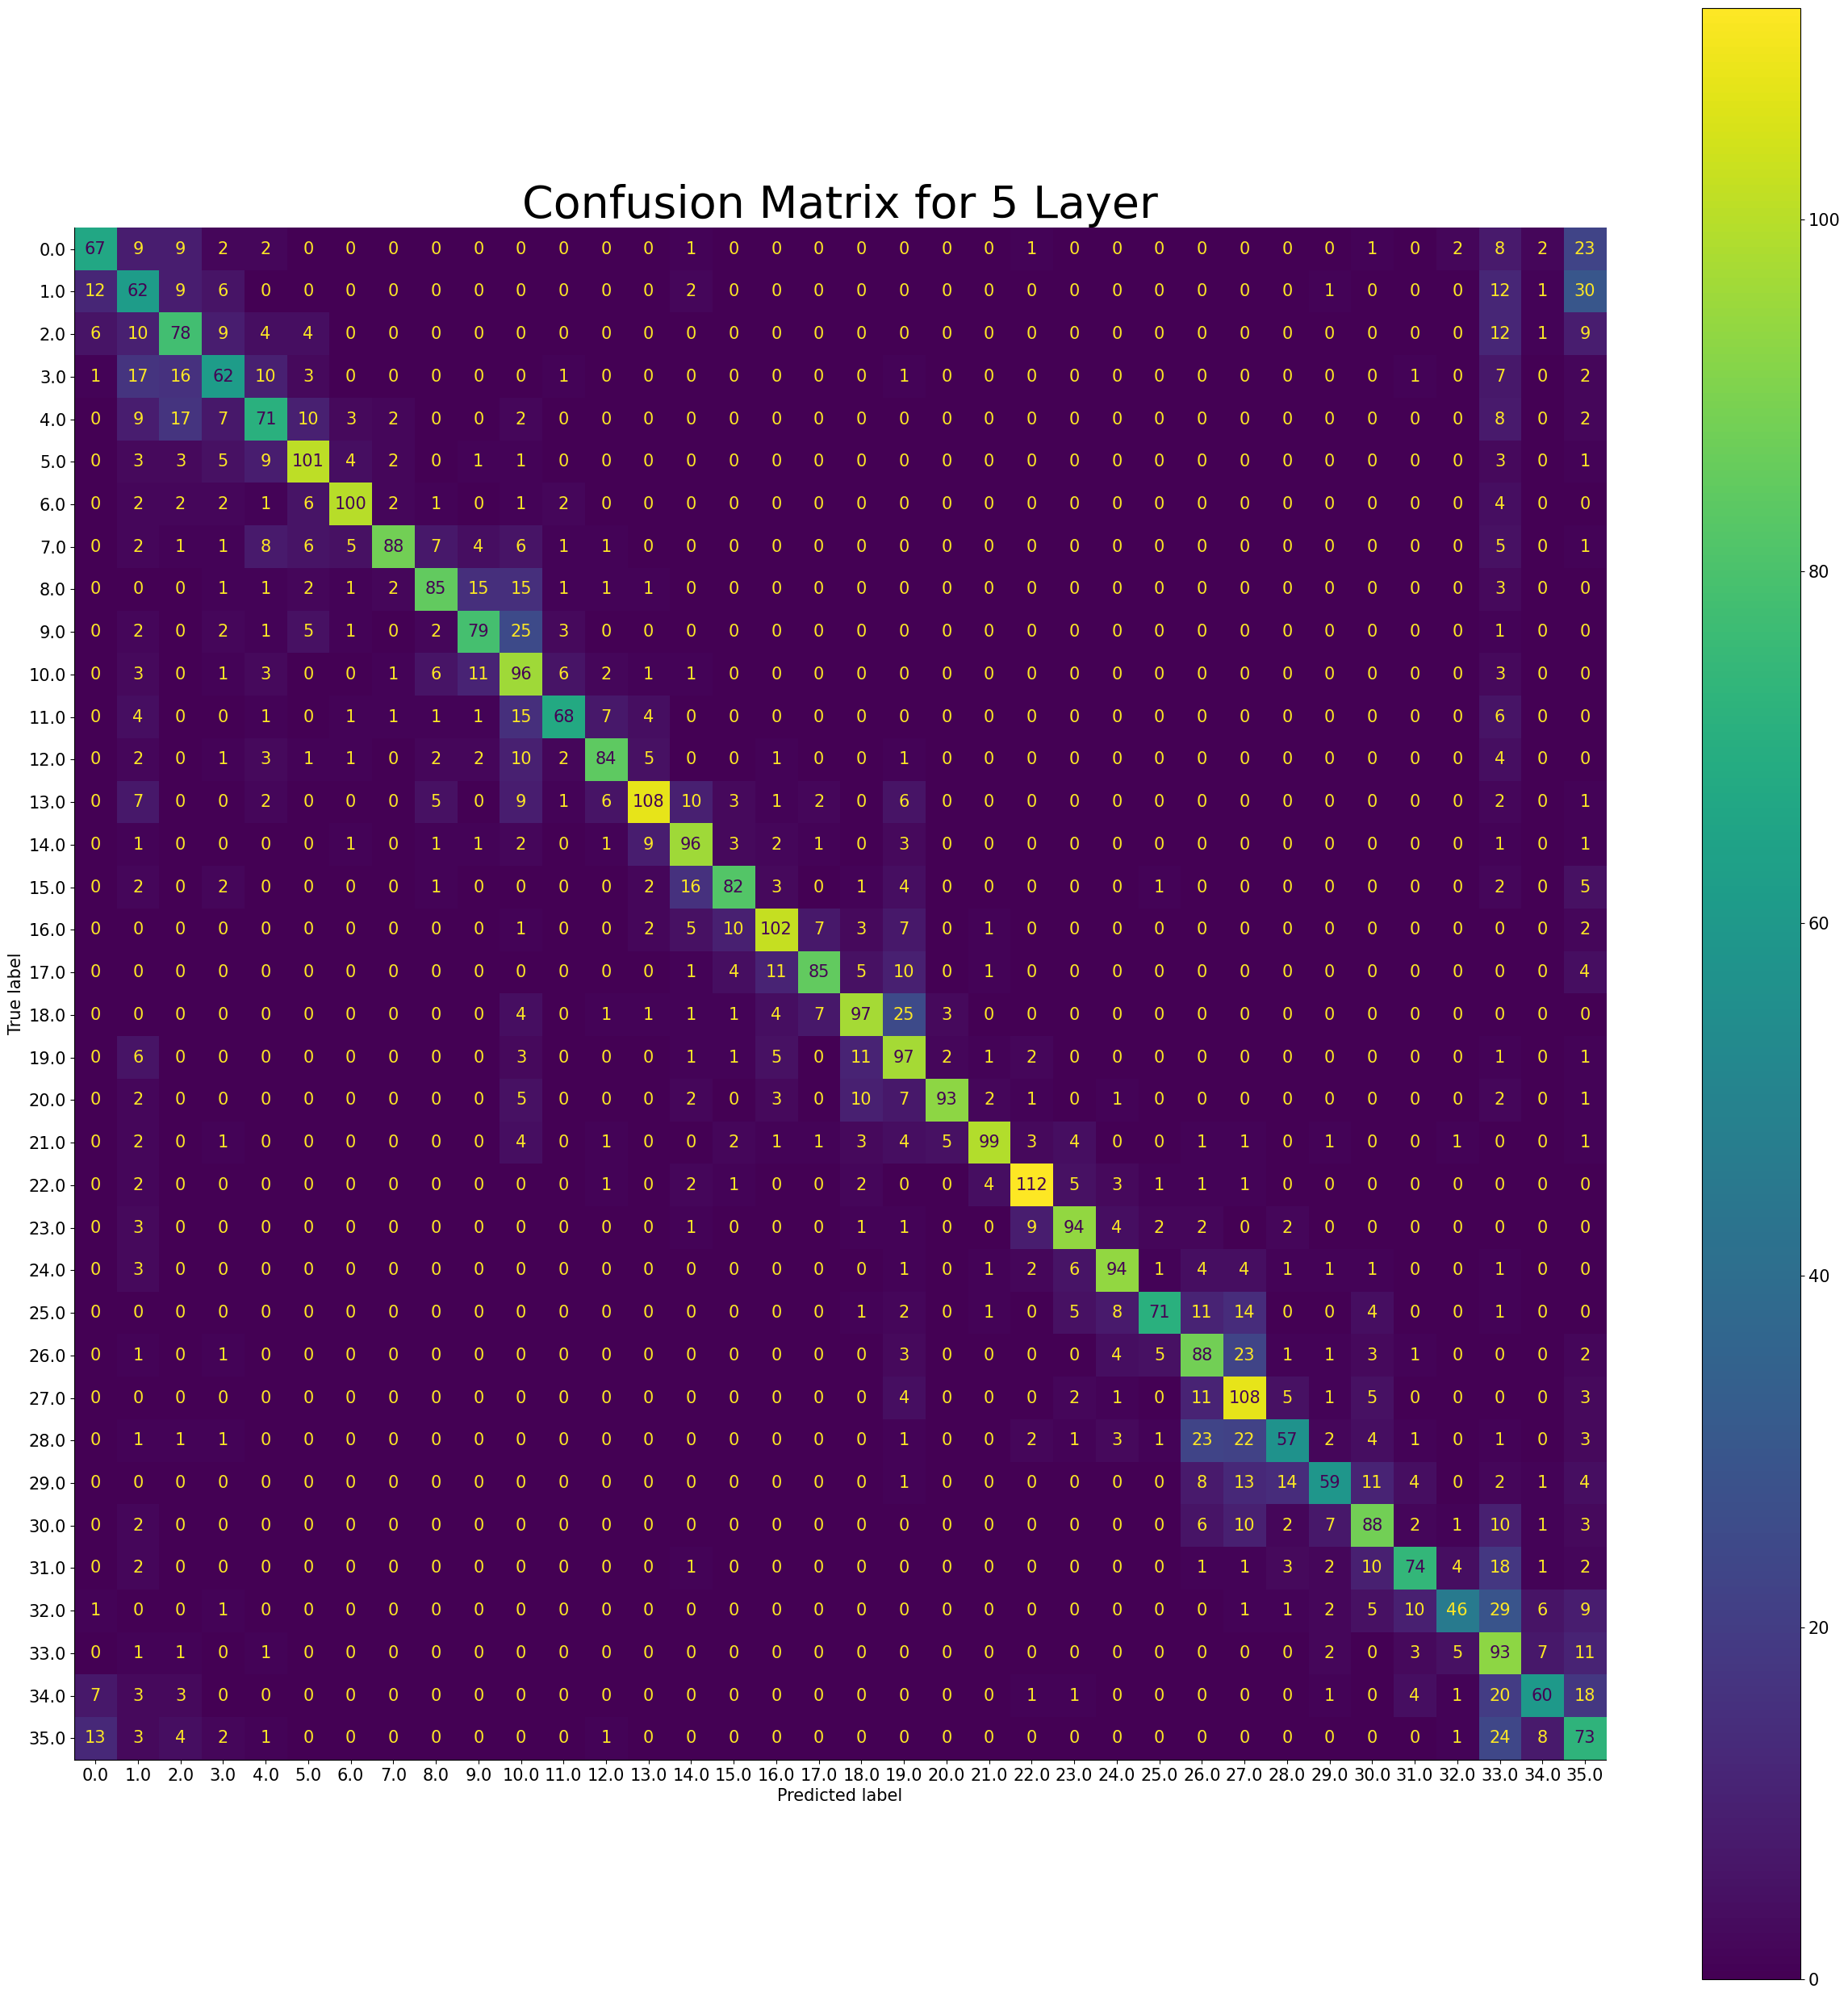

CPU times: total: 1min 47s
Wall time: 1min 47s


In [39]:
%%time
tree_5 = train_kfold(DecisionTreeClassifier(max_depth=10), X_5, y_5, kf, '5 Layer')

In [41]:
def get_important_neurons(model: DecisionTreeClassifier, neuron_indexes: list[int], filter_zeros: bool = False, get_zeroes: bool = False, permute_importance: bool = False, save_df: bool = False) -> list[tuple[int, float]]:
    """
    Get indices of neurons sorted by importance.

    Args:
        model: trained classification model
        filter_zeros: whether to filter out neurons with zero importance
        permute_importance: whether to use permutation importance instead of feature importance

    Returns:
        neuron_importance: array of tuples containing neuron indices and their importance
    """
    assert not (filter_zeros and get_zeroes), "cannot filter and get zeroes at the same time"
    model_importance = permutation_importance(model, X_test, y_test) if permute_importance else model.feature_importances_
    neuron_importance = list(zip(neuron_indexes, model_importance))
    if filter_zeros:
        neuron_importance = [neuron for neuron in neuron_importance if neuron[1] > 0]
        neuron_importance.sort(key=lambda x: x[1], reverse=True)
    elif get_zeroes:
        neuron_importance = [neuron for neuron in neuron_importance if neuron[1] == 0]

    if save_df:
        df = pd.DataFrame(neuron_importance, columns=['neuron_index', 'importance'])
        return df
    
    return neuron_importance

def plot_important_neurons(model: DecisionTreeClassifier, index, n_largest: int = 10, filter_zeros: bool = False, permute_importance: bool = False) -> None:
    """
    Plot the importance of neurons in a model.

    Args:
        model: trained classification model
    """
    model_importance = permutation_importance(model, X_test, y_test) if permute_importance else model.feature_importances_
    if filter_zeros:
        neuron_importance = [neuron for neuron in neuron_importance if neuron[1] > 0]

    feat_importances = pd.Series(model_importance, index=index)
    feat_importances.nlargest(n_largest).sort_values().plot(kind='barh', color='palevioletred', figsize=(10, 10))
    plt.xlabel('importance')
    plt.ylabel('neuron index')

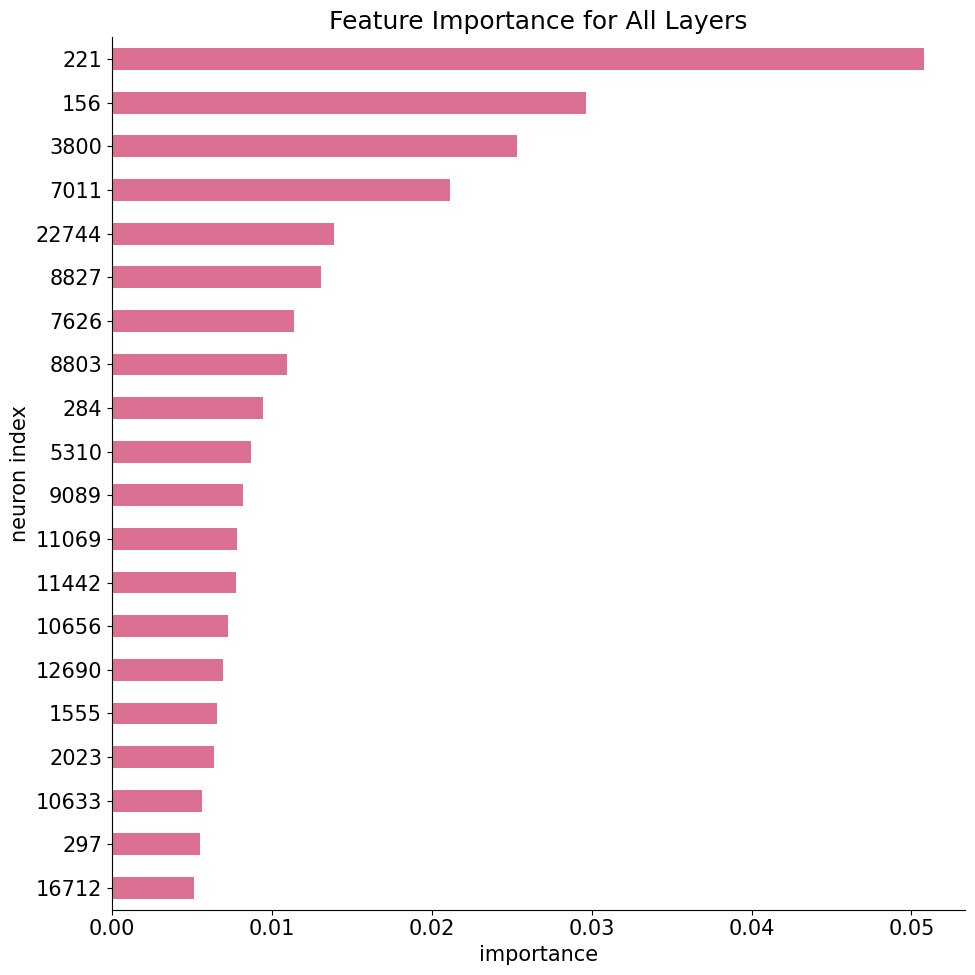

In [42]:
plot_important_neurons(full_tree, sresp_df.columns, n_largest=20)
plt.title('Feature Importance for All Layers')
plt.show()

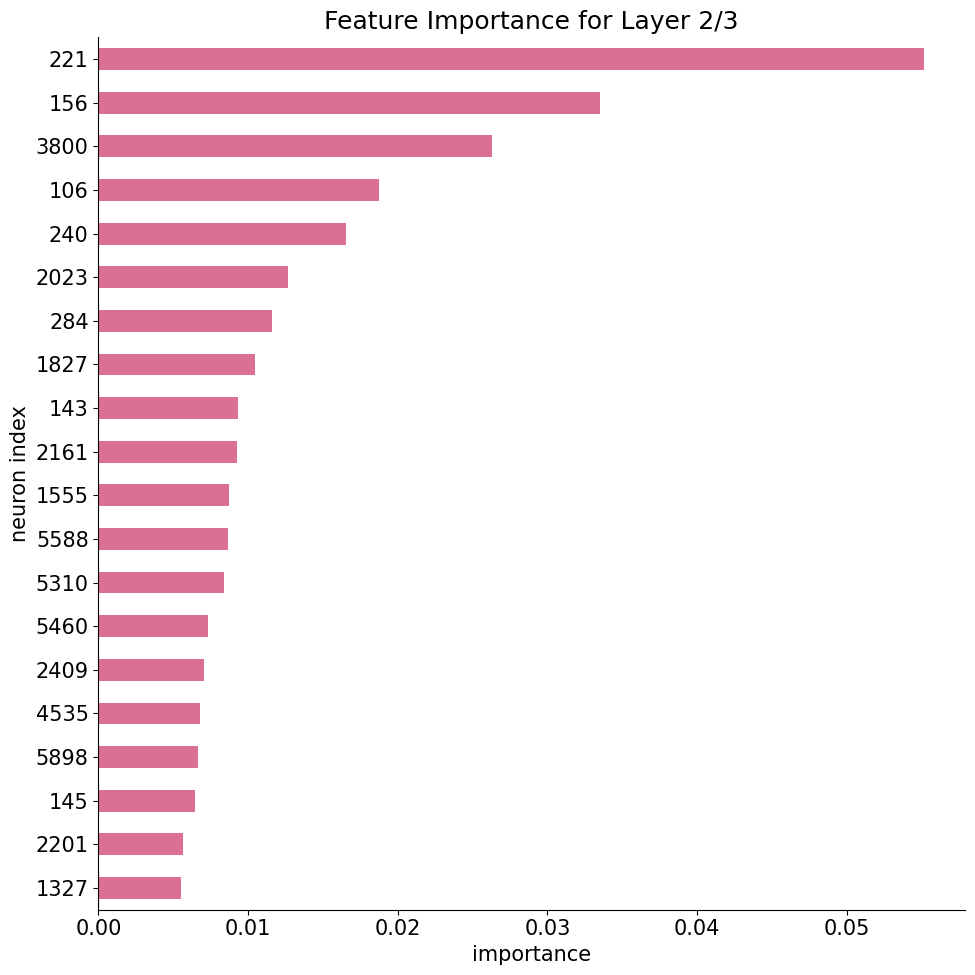

In [44]:
plot_important_neurons(tree_2_3, sresp_2_3_df.columns, n_largest=20)
plt.title('Feature Importance for Layer 2/3')
plt.show()

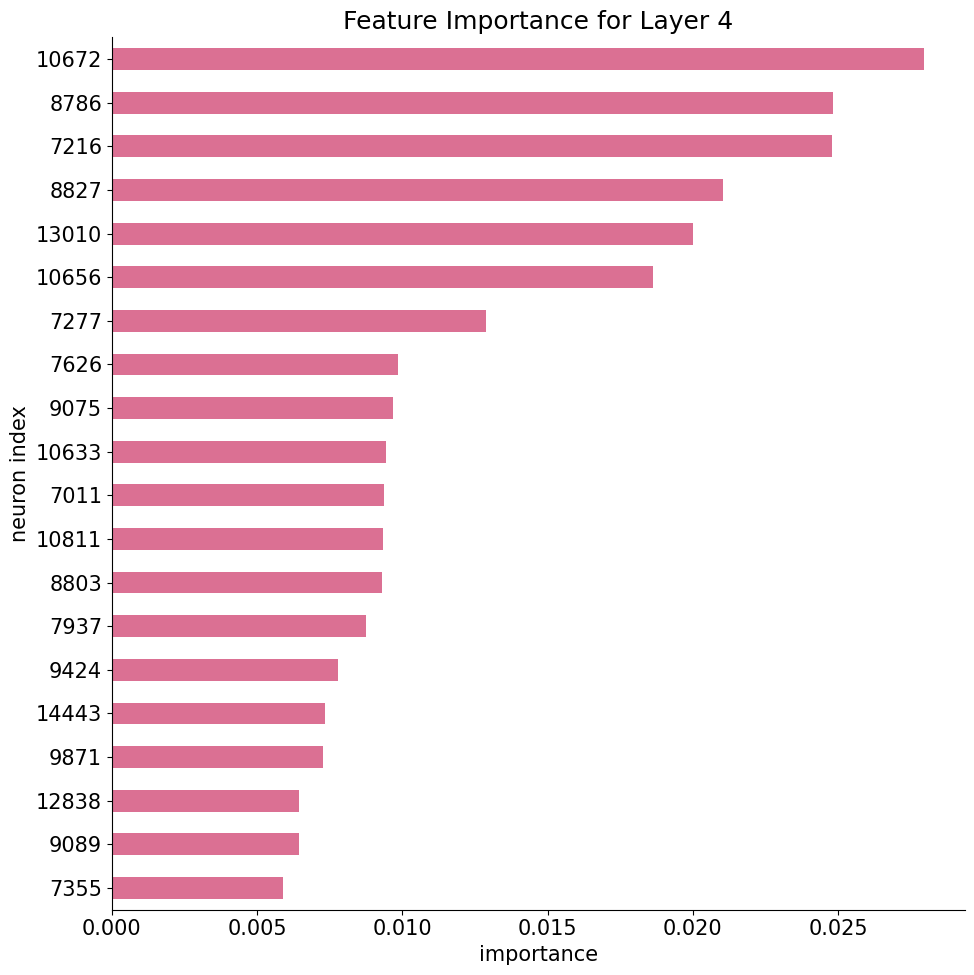

In [45]:
plot_important_neurons(tree_4, sresp_4_df.columns, n_largest=20)
plt.title('Feature Importance for Layer 4')
plt.show()

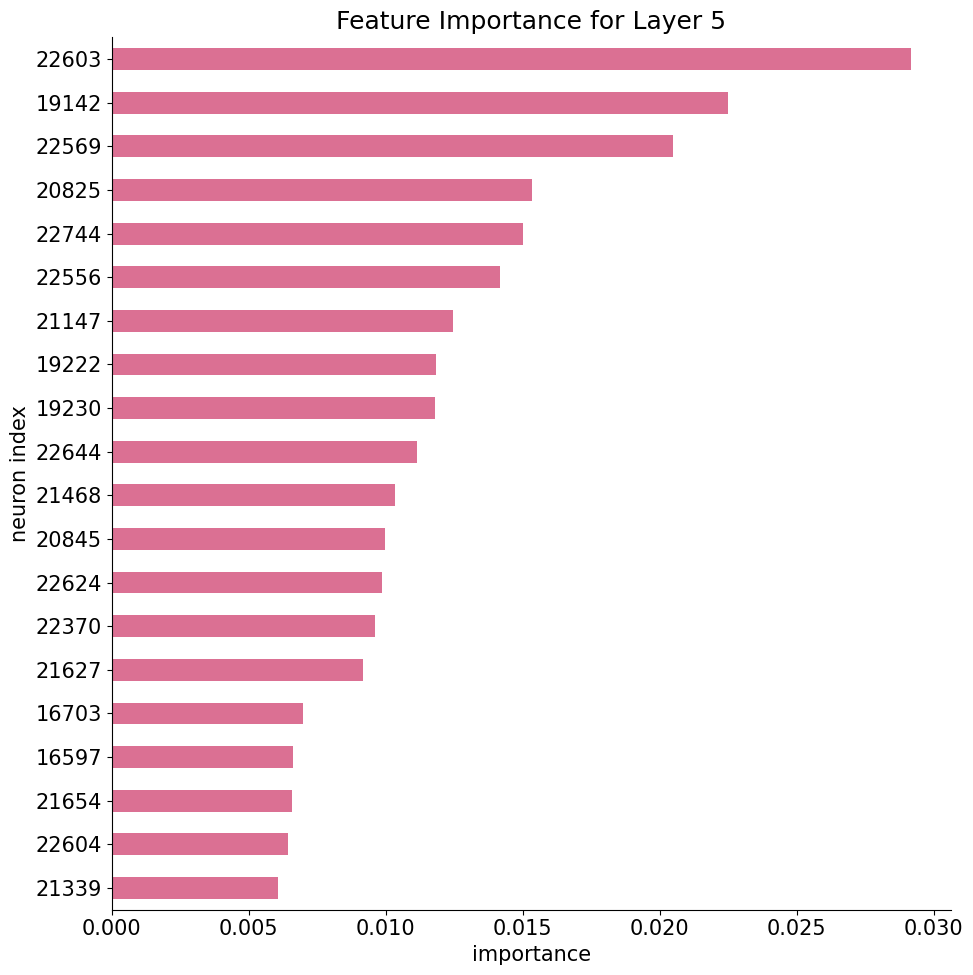

In [46]:
plot_important_neurons(tree_5, sresp_5_df.columns, n_largest=20)
plt.title('Feature Importance for Layer 5')
plt.show()

In [38]:
# get and save important neurons for each layer and all layers in dataframe
full_importance = get_important_neurons(full_tree, sresp_df.columns, filter_zeros=True, save_df=True)
layer_2_3_importance = get_important_neurons(tree_2_3, sresp_2_3_df.columns, filter_zeros=True, save_df=True)
layer_4_importance = get_important_neurons(tree_4, sresp_4_df.columns, filter_zeros=True, save_df=True)
layer_5_importance = get_important_neurons(tree_5, sresp_5_df.columns, filter_zeros=True, save_df=True)

full_importance.to_csv('./data/full_importance.csv', index=False)
layer_2_3_importance.to_csv('./data/layer_2_3_importance.csv', index=False)
layer_4_importance.to_csv('./data/layer_4_importance.csv', index=False)
layer_5_importance.to_csv('./data/layer_5_importance.csv', index=False)

In [39]:
# get and save zero importance neurons for each layer and all layers in dataframe
full_zero_importance = get_important_neurons(full_tree, sresp_df.columns, get_zeroes=True, save_df=True)
layer_2_3_zero_importance = get_important_neurons(tree_2_3, sresp_2_3_df.columns, get_zeroes=True, save_df=True)
layer_4_zero_importance = get_important_neurons(tree_4, sresp_4_df.columns, get_zeroes=True, save_df=True)
layer_5_zero_importance = get_important_neurons(tree_5, sresp_5_df.columns, get_zeroes=True, save_df=True)

full_zero_importance.to_csv('./data/full_zero_importance.csv', index=False)
layer_2_3_zero_importance.to_csv('./data/layer_2_3_zero_importance.csv', index=False)
layer_4_zero_importance.to_csv('./data/layer_4_zero_importance.csv', index=False)
layer_5_zero_importance.to_csv('./data/layer_5_zero_importance.csv', index=False)

In [40]:
def load_importance_data(zero_importance: bool = False, to_dict: bool = False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load importance data for each layer and all layers.

    Args:
        zero_importance: whether to load zero importance data
        to_dict: whether to return dataframes as a dictionary

    Returns:
        full_importance: dataframe of all layers importance
        layer_2_3_importance: dataframe of layer 2/3 importance
        layer_4_importance: dataframe of layer 4 importance
        layer_5_importance: dataframe of layer 5 importance
    """
    assert not (zero_importance and not os.path.exists('./data/full_zero_importance.csv')), "zero importance data does not exist"
    assert not (not zero_importance and not os.path.exists('./data/full_importance.csv')), "importance data does not exist"
    if zero_importance:
        full_importance = pd.read_csv('./data/full_zero_importance.csv')
        layer_2_3_importance = pd.read_csv('./data/layer_2_3_zero_importance.csv')
        layer_4_importance = pd.read_csv('./data/layer_4_zero_importance.csv')
        layer_5_importance = pd.read_csv('./data/layer_5_zero_importance.csv')
    else:
        full_importance = pd.read_csv('./data/full_importance.csv')
        layer_2_3_importance = pd.read_csv('./data/layer_2_3_importance.csv')
        layer_4_importance = pd.read_csv('./data/layer_4_importance.csv')
        layer_5_importance = pd.read_csv('./data/layer_5_importance.csv')

    if to_dict:
        return full_importance.to_dict("list"), layer_2_3_importance.to_dict("list"), layer_4_importance.to_dict("list"), layer_5_importance.to_dict("list")
    return full_importance, layer_2_3_importance, layer_4_importance, layer_5_importance

In [41]:
full_zero_importance, layer_2_3_zero_importance, layer_4_zero_importance, layer_5_zero_importance = load_importance_data(zero_importance=True, to_dict=True)

In [42]:
def plot_random_forest(model: RandomForestClassifier, filenames: str, feature_names: list[str]):
    """
    Plot a random forest model.

    Args:
        model: trained random forest model
    """
    for num, estimator in enumerate(model.estimators_):
        print(f'plotting tree {num}')
        export_graphviz(estimator, out_file=f'./images/{filenames}-{str(num)}.dot', feature_names=feature_names, class_names=model.classes_.astype("str"), rounded=True, filled=True)
        subprocess.run(['dot', '-Tpng', f'./images/{filenames}-{str(num)}.dot', '-o', f'./images/{filenames}-{str(num)}.png', '-Gdpi=600'])
        # display(Image(f'./images/{filenames}-{str(num)}.png'))